In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.coord_attention import CoordAttentionResNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/coord-att")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = CoordAttentionResNet(output_size=num_class, key=50).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
CoordAttentionResNet                                    --
├─Sequential: 1-1                                       --
│    └─ConvBnRelu: 2-1                                  --
│    │    └─Conv2d: 3-1                                 9,408
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─ReLU: 3-3                                   --
│    └─MaxPool2d: 2-2                                   --
├─Sequential: 1-2                                       --
│    └─ResBlock: 2-3                                    --
│    │    └─BottleNeck: 3-4                             64,784
│    │    └─ConvBnRelu: 3-5                             16,896
│    └─ResBlock: 2-4                                    --
│    │    └─BottleNeck: 3-6                             77,072
│    │    └─Identity: 3-7                               --
│    └─ResBlock: 2-5                                    --
│    │    └─BottleNeck: 3-8        

# training

In [11]:
epochs = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epochs, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [14]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [17:58<00:00,  1.52it/s]


epoch 1 : 0.025291525085358754


100%|██████████| 1636/1636 [06:10<00:00,  4.41it/s]


epoch 2 : 0.018949594668597712


100%|██████████| 1636/1636 [06:10<00:00,  4.41it/s]


epoch 3 : 0.01562203953502595


100%|██████████| 1636/1636 [06:10<00:00,  4.41it/s]


epoch 4 : 0.013327953619438435


100%|██████████| 1636/1636 [06:10<00:00,  4.41it/s]


epoch 5 : 0.011874872488214483


100%|██████████| 1636/1636 [06:12<00:00,  4.39it/s]


epoch 6 : 0.010468818714473884


100%|██████████| 1636/1636 [06:11<00:00,  4.40it/s]


epoch 7 : 0.009300321593102463


100%|██████████| 1636/1636 [06:10<00:00,  4.42it/s]


epoch 8 : 0.00830661527477182


100%|██████████| 1636/1636 [06:08<00:00,  4.44it/s]


epoch 9 : 0.007432138972117595


100%|██████████| 1636/1636 [06:08<00:00,  4.43it/s]

epoch 10 : 0.006762483415771948


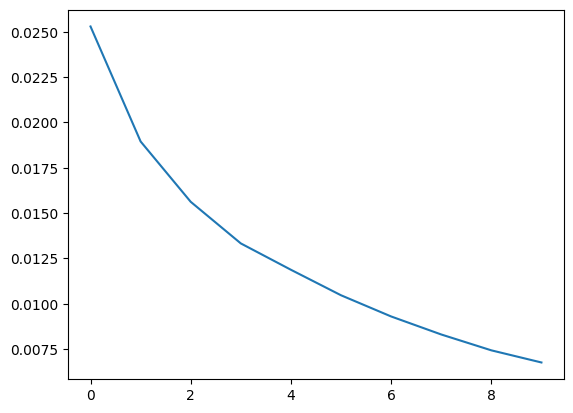

In [15]:
plt.plot(training_loss)

# inference

In [16]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [17]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [19]:
evaluator = ClassificationEvaluator(num_class, device)

In [20]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:37<00:00, 10.41it/s]

[[4177  179   42   57  179   43   28   45   65   48]
 [  39 2441    8   22   36    2   37    9   21    8]
 [  21   34 1311    6   13    2    7   17   24   11]
 [   1    5    1 1998    9    3    0    0   89    6]
 [  27   14    3   55 2918    8    2    5   56   10]
 [ 124   15   14   21   42 1375    2    4   27   44]
 [  80  209   23    7   52    3 1366  101   20    5]
 [  55   46   21    5   71   14   45 1502   41   20]
 [   3   10    1  134   13    3    0    2 4646    9]
 [  22    7    9   22   45   15    0    9  134 1599]]


In [21]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.8589348139008842
cavallo   : 0.9306138009912314
elefante  : 0.9066390041493776
farfalla  : 0.9460227272727273
gallina   : 0.9418979987088444
gatto     : 0.8243405275779376
mucca     : 0.7320471596998929
pecora    : 0.8252747252747252
ragno     : 0.9637004770794441
scoiattolo: 0.8587540279269602


In [22]:
per_class_acc.mean()

0.8788225262582025

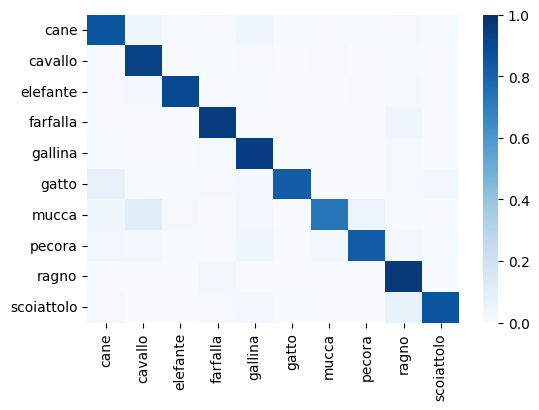

In [23]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [24]:
model_path = artifact_path / 'coord-att-resnet50.pth'

In [25]:
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

'97.44MB'

In [27]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>